### The porject is tested on python 3.9 with the following libs installed.

* matplotlib
* numpy
* pandas
* Pillow
* scikit-learn
* tensorflow

In [5]:
import os
import shutil
import sys
import time

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Consts and Util functions

In [6]:
RANDOM_SEED = 255
IMAGE_SHAPE = (224, 224, 3)
ALL_HEMORRHAGE_TYPES = ["epidural", "intraparenchymal", "intraventricular", "subarachnoid", "subdural"]
ALL_IMAGE_DIRS = ["epidural", "intraparenchymal", "intraventricular", "subarachnoid", "subdural", "normal", "multi"]

In [7]:
def stat_shape(df):
    count_table = pd.crosstab(df['hemorrhage_type'], df['shape'])
    print(count_table)


def split_df(df, train_ratio=0.7, val_ratio=0.2, random_state=255):
    test_ratio = 1 - train_ratio - val_ratio
    train_df, validate_test_df = train_test_split(df, test_size=(1 - train_ratio), random_state=random_state)
    test_df, validate_df = train_test_split(validate_test_df, test_size=(val_ratio / (test_ratio + val_ratio)))

    return train_df, validate_df, test_df


def load_images(file_paths, img_size = IMAGE_SHAPE):

    # init images
    if len(img_size) == 2:
        img_size = img_size + (3,)
    images = np.zeros((len(file_paths), *img_size))
    
    start_time = time.time()  # Log the start time
    for idx, img_file in enumerate(file_paths):
        img = tf.keras.preprocessing.image.load_img(img_file, target_size=img_size[0:2])
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        # Convert the NumPy array to float32 data type
        img_array = img_array.astype('float32')
        
        images[idx] = img_array/255.0

        if idx % 100 == 0:
            end_time = time.time()  # Log the end time
            elapsed_time = end_time - start_time
            print(f"Time taken to load {idx} images: {elapsed_time:.2f} seconds")

    return images

def load_image(path, img_size=IMAGE_SHAPE):
    img = tf.keras.preprocessing.image.load_img(path, target_size=img_size[0:2])
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    return img_array/255.0



def read_mask_file(mask_file, target_size=IMAGE_SHAPE):
    image = Image.open(mask_file)

    # Convert the image to grayscale (black and white)
    image_gray = image.convert('L')

    # Resize the image to 256x256
    image_resized = image_gray.resize(target_size[0:2], Image.LANCZOS)

    # Convert the image to a NumPy array and normalize the values
    image_array = np.array(image_resized) / 255.0

    # Add the channel dimension (1) to the array
    image_array = image_array.reshape(IMAGE_SHAPE[0:2] + (1,))

    return image_array


def load_image_mask_by_table(table):
    all_images = []
    all_masks = []
    for index, row in table.iterrows():
        image_file = "./renders/%s/brain_window/%s.jpg" % (row['hemorrhage_type'], row['image'])
        mask_file = "./seg-label/%s/%s" % (row['hemorrhage_type'], row['mask'])
        image = load_image(image_file)
        mask = read_mask_file(mask_file)

        all_images.append(image)
        all_masks.append(mask)
    
    return all_images, all_masks

## Load Models

In [10]:
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.optimizers import Adam

def build_VGG16(n_classes):
    # Load pre-trained VGG16 model without the top classification layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Add custom layers for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of the base model (pre-trained VGG16)
    for layer in base_model.layers:
        layer.trainable = False

    return model



def multilabel_mobilenet(num_classes):
    # Load the pre-trained MobileNetV2 model without the top classification layer
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE)

    # Add a global average pooling layer
    x = GlobalAveragePooling2D()(base_model.output)

    # Add a custom classification head with a sigmoid activation for multilabel classification
    output = Dense(num_classes, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=output)

    return model


def unet_mobilenetv2(input_shape=IMAGE_SHAPE, num_classes=1):
    """ Construct a U-Net model with MobileNetV2 encoder

    Args:
        input_shape: Input image shape
        num_classes: Number of classes
    """
    # Load pre-trained MobileNetV2 as the encoder
    encoder = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Encoder layers
    s1 = encoder.get_layer('block_1_expand_relu').output
    s2 = encoder.get_layer('block_3_expand_relu').output
    s3 = encoder.get_layer('block_6_expand_relu').output
    s4 = encoder.get_layer('block_13_expand_relu').output
    encoder_output = encoder.get_layer('block_16_project').output

    # Decoder layers
    x = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(encoder_output)
    x = tf.keras.layers.Concatenate()([x, s4])

    x = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.Concatenate()([x, s3])

    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.Concatenate()([x, s2])

    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.Concatenate()([x, s1])

    x = tf.keras.layers.Conv2DTranspose(num_classes, (3, 3), strides=(2, 2), padding='same')(x)

    # Output layer
    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    output = tf.keras.layers.Activation(activation)(x)

    # Construct the U-Net model with MobileNetV2 encoder
    model = tf.keras.Model(inputs=encoder.input, outputs=output)

    return model

## Test

In [11]:
def test_image(image_name):
    image_path = "./test_images/%s.jpg" % image_name
    # check file exist
    if not os.path.isfile(image_path):
        print("Image %s not found" % image_path)
        sys.exit(1)
    print(image_path)
    
    # read image
    images = load_images([image_path])
    # test image valid
    model_cleaning = build_VGG16(len(ALL_HEMORRHAGE_TYPES))
    model_cleaning.load_weights('./models/cleaning-1681785936-weight.h5')
    # predict
    valid_predictions = model_cleaning.predict(images)
    # print predictions
    valid_value = np.argmax(valid_predictions, axis=1)
    if valid_value in [0, 4]:
        print("Data cleaning classification result : %d" % valid_value)
        print("Image %s is not valid for following classification and segmentation" % image_name)
        return
    print("Image %s is valid for following classification and segmentation, value = %d" % (image_name, valid_value))

    # classify
    model_classify = multilabel_mobilenet(len(ALL_HEMORRHAGE_TYPES))
    model_classify.load_weights('./models/classify_weights_epoch_12.h5')
    # predict
    classify_predictions = model_classify.predict(images)
    threshold = 0.5
    predict_value = (classify_predictions >= threshold).astype(int)[0]

    # find from label by image name
    df = pd.read_csv('./labels/hemorrhage-labels-shape.csv')
    df = df[df['Image'] == image_name]
    real_value = df[ALL_HEMORRHAGE_TYPES].values[0]

    real_type = hemorrhage_types_to_str(real_value)
    
    print("Real Hemorrhage Type : %s" % real_type)
    print("Predict Hemorrhage Type : %s" % hemorrhage_types_to_str(predict_value))

    if real_type == 'normal':
        print("Image %s is normal, no need to do segmentation" % image_name)
        return


    # segmentation
    model_segmentation = unet_mobilenetv2(input_shape=IMAGE_SHAPE, num_classes=1)
    model_segmentation.load_weights('./models/seg_unet_1550_59_weight.h5')
    # predict
    segmentation_predictions = model_segmentation.predict(images*255.0)
    print(segmentation_predictions.shape)

    # read mask
    mask_file_path = "./test_images/%s_mask.png" % image_name
    # check mask file exist
    if not os.path.isfile(mask_file_path):
        print("Mask %s not found" % mask_file_path)
    else:
        masks = read_mask_file(mask_file_path)

    # Plot the results
    plt.figure()

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(images[0])

    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(masks)

    plt.subplot(1, 3, 3)
    plt.title("Predicted mask")
    plt.imshow(segmentation_predictions[0])
    
    # print the whole array
    np.set_printoptions(threshold=sys.maxsize)

    plt.show()

def hemorrhage_types_to_str(hemorrhage_types):
    result =  ','.join([ALL_HEMORRHAGE_TYPES[i] for i in range(len(hemorrhage_types)) if hemorrhage_types[i] == 1])
    if not result:
        result = 'normal'
    return result

def select_random_test_image():
    # select image file from test_images directory with .jpg extension
    test_images = [f for f in os.listdir('./test_images') if f.endswith('.jpg')]
    # select random image
    image_name = np.random.choice(test_images)
    # remove .jpg extension
    image_name = image_name[:-4]
    return image_name

## Test on a randomly selected test image

* If data cleaning result is 0 or 4, the process will stop.
* If it is the normal type, no segmentation will be executed.

./test_images/ID_6b76c33fb.jpg
Time taken to load 0 images: 0.02 seconds


2023-04-22 13:18:33.326486: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 244ms/step
Image ID_6b76c33fb is valid for following classification and segmentation, value = 1
1/1 [==============================] - 0s 230ms/step
Real Hemorrhage Type : intraventricular
Predict Hemorrhage Type : intraparenchymal,intraventricular
1/1 [==============================] - 0s 365ms/step
(1, 224, 224, 1)


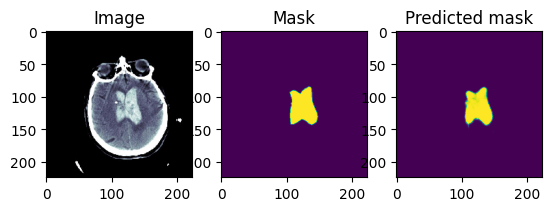

In [12]:
image_name = select_random_test_image()
test_image(image_name)

* The following images are not used in training and included in ./test_images
* If it is not a 'normal' type, a mask file is also included in ./test_images
* You can test a image like this:  test_image('ID_58d207fbb')

ID_e1a79991d    ID_045196c9f    ID_fa5740d59    ID_7671c259d    ID_4d9948949
ID_8178e7fba    ID_76b0cff2d    ID_532e51d84    ID_1a70c9ed9    ID_1557d48a2
ID_6b76c33fb    ID_2af490b16    ID_5fc155eb3    ID_e3966717c    ID_682fd93f0
ID_a708bc33e    ID_a6ca3cbbd    ID_9857d531d    ID_87220a03d    ID_804a67a23
ID_58d207fbb    ID_9c6b6bc7c    ID_53484732e    ID_9e21c3e22    ID_30597f32c
ID_521442570    ID_192001287    ID_980a8c980    ID_7708d5f0a    ID_b3e385fb0
ID_019ec91f3    ID_00d1e2d08    ID_003f54650    ID_00daa2da4    ID_010038691
ID_00b37259e    ID_01bf49f13    ID_01029fa96    ID_00716e4cc    ID_019d19240

./test_images/ID_8178e7fba.jpg
Time taken to load 0 images: 0.01 seconds
1/1 [==============================] - 0s 153ms/step
Image ID_8178e7fba is valid for following classification and segmentation, value = 2
1/1 [==============================] - 0s 233ms/step
Real Hemorrhage Type : intraparenchymal
Predict Hemorrhage Type : intraparenchymal
1/1 [==============================] - 0s 445ms/step
(1, 224, 224, 1)


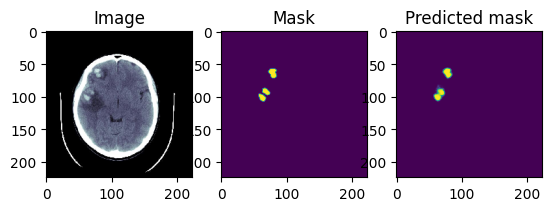

In [14]:
test_image('ID_8178e7fba')